In [1]:
import os

import numpy as np
import pandas as pd

# general import for smrt
from smrt import make_snowpack, make_model, sensor_list
from smrt.core.model import make_emmodel
from smrt.emmodel.iba import derived_IBA

from smrt.utils import dmrt_qms_legacy

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib widget

# 'snowpack' preparation

In [2]:
# generation snowpack with increasing density from 0 to 916 kg/m3

# grain radius:
a = 0.4e-3

density = np.arange(1, 916, 10)

sp0 = [make_snowpack([100000], "sticky_hard_spheres", density=dens, 
                     temperature=273, 
                     radius=a, 
                     liquid_water=0, 
                     stickiness=0.2) for dens in density]

layers0 = [s.layers[0] for s in sp0]

sp = []
for s in sp0:
    news = s.copy()
    if s.layers[0].frac_volume > 0.5:
        news.layers = [s.layers[0].inverted_medium()]
    sp.append(news)
    
layers = [lay.inverted_medium() if lay.frac_volume > 0.5 else lay for lay in layers0]

# 'sensor' creation

In [3]:
sensor = sensor_list.amsre("19V")

In [4]:

def run(theory, sp, **kwargs):
    m = make_model(theory, "dort", rtsolver_options=dict(n_max_stream=128))
    return m.run(sensor, sp, parallel_computation=True)

def getl(obj, attr):
    return obj.other_data[attr]


iba = run('iba', sp)
dmrt_qca = run('dmrt_qca_shortrange', sp)
dmrt_qcacp = run('dmrt_qcacp_shortrange', sp)
sce08 = run('sce_rechtsman08', sp)
sce21 = run('sce_torquato21', sp)
symsce = run('symsce_torquato21', sp)

/home/picardgh/miniconda3/envs/smrt/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:635: ComplexWarning: Casting complex values to real discards the imaginary part
  h = Ninterv * np.asarray(dx, dtype=float)
/home/picardgh/miniconda3/envs/smrt/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:635: ComplexWarning: Casting complex values to real discards the imaginary part
  h = Ninterv * np.asarray(dx, dtype=float)
/home/picardgh/miniconda3/envs/smrt/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:635: ComplexWarning: Casting complex values to real discards the imaginary part
  h = Ninterv * np.asarray(dx, dtype=float)
/home/picardgh/miniconda3/envs/smrt/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:635: ComplexWarning: Casting complex values to real discards the imaginary part
  h = Ninterv * np.asarray(dx, dtype=float)
/home/picardgh/miniconda3/envs/smrt/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:635: ComplexWarning: Casting 

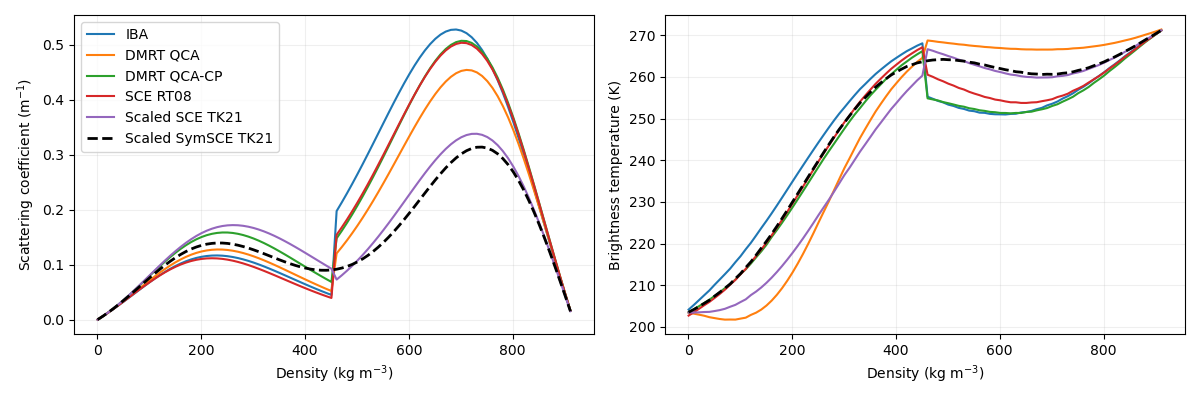

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(density, getl(iba, "ks"), label="IBA")
axs[0].plot(density, getl(dmrt_qca, "ks"), '', label='DMRT QCA')
axs[0].plot(density, getl(dmrt_qcacp, "ks"), '-', label='DMRT QCA-CP')
axs[0].plot(density, getl(sce08, "ks"), label='SCE RT08')
axs[0].plot(density, getl(sce21, "ks"), label='Scaled SCE TK21')
axs[0].plot(density, getl(symsce, "ks"), 'k--', lw=2, label='Scaled SymSCE TK21')

axs[0].legend(loc='best')
axs[0].set_xlabel("Density (kg m$^{-3}$)")
axs[0].set_ylabel("Scattering coefficient (m$^{-1}$)")
axs[0].grid(alpha=0.2)


axs[1].plot(density, iba.TbV(), label="IBA")
axs[1].plot(density, dmrt_qca.TbV(), '', label='DMRT QCA')
axs[1].plot(density, dmrt_qcacp.TbV(), '-', label='DMRT QCA-CP')
axs[1].plot(density, sce08.TbV(), label='SCE RT08')
axs[1].plot(density, sce21.TbV(), label='Scaled SCE TK21')
axs[1].plot(density, symsce.TbV(), 'k--', lw=2, label='Scaled SymSCE TK21')

axs[0].legend(loc='best')
for i in [0, 1]:
    axs[i].set_xlabel("Density (kg m$^{-3}$)")
    axs[i].grid(alpha=0.2)
    
axs[0].set_ylabel("Scattering coefficient (m$^{-1}$)")
axs[1].set_ylabel("Brightness temperature (K)")

plt.tight_layout()

plt.savefig("fig-scattering-coefficient-vs-density.pdf")

# scattering coefficient versus frequency // grain size

In [6]:
# Grain size:
a = 0.5e-3
# Density:
density = 300

freqs = np.arange(1, 200, 5)

sp = make_snowpack([10], "sticky_hard_spheres", density=density, temperature=265, radius=a, liquid_water=0, stickiness=0.2)


def run_mf(theory, layer):
    return [make_emmodel(theory, sensor_list.passive(f * 1e9, theta=50), layer) for f in freqs]

def get_mf(sensor, attribute):
    return np.array([getattr(s, attribute) for s in sensor])

In [7]:
mf_symsce = run_mf('symsce_torquato21_shortrange', sp.layers[0])
mf_symscele = run_mf('symsce_torquato21', sp.layers[0])
mf_iba = run_mf('iba', sp.layers[0])
mf_dmrt = run_mf('dmrt_qca_shortrange', sp.layers[0])
mf_dmrt_cp = run_mf('dmrt_qcacp_shortrange', sp.layers[0])
mf_sce = run_mf('sce_rechtsman08', sp.layers[0])

/home/picardgh/miniconda3/envs/smrt/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:635: ComplexWarning: Casting complex values to real discards the imaginary part
  h = Ninterv * np.asarray(dx, dtype=float)
/home/picardgh/MW/Microsnow/smrt/smrt/emmodel/dmrt_qcacp_shortrange.py:114: UserWarning: Grain diameter is too large for DMRT_QCACP_ShortRange resulting in single scattering albedo larger than 1.It is recommended to decrease the size or used an alternative emmodel able to do Mie calculations.
  warn("Grain diameter is too large for DMRT_QCACP_ShortRange resulting in single scattering albedo larger than 1."


Grain diameter is too large for DMRT_QCA_ShortRange resulting in single scattering albedo larger than 1.It is recommended to decrease the size or used an alternative emmodel able to do Mie calculations.
Grain diameter is too large for DMRT_QCA_ShortRange resulting in single scattering albedo larger than 1.It is recommended to decrease the size or used an alternative emmodel able to do Mie calculations.
Grain diameter is too large for DMRT_QCA_ShortRange resulting in single scattering albedo larger than 1.It is recommended to decrease the size or used an alternative emmodel able to do Mie calculations.
Grain diameter is too large for DMRT_QCA_ShortRange resulting in single scattering albedo larger than 1.It is recommended to decrease the size or used an alternative emmodel able to do Mie calculations.
Grain diameter is too large for DMRT_QCA_ShortRange resulting in single scattering albedo larger than 1.It is recommended to decrease the size or used an alternative emmodel able to do Mie

# DMRT-QMS simulations

In [8]:
if False:  # set to true to generate DMRT-QMS files.
    # run DMRT-QMS
    layer = sp.layers[0]
    for f in freqs:
        res = dmrt_qms_legacy.dmrt_qms_emmodel(sensor_list.passive(f * 1e9, theta=50), layer) 
        print(f, res.ks, res.ka)

filename = f"data/results-dmrt-qms-{a*1000}mm-sticky-{density}kgm3.csv"
mf_dmrt_qms = pd.read_csv(filename, sep=' ', comment='#')
print(filename)

data/results-dmrt-qms-0.5mm-sticky-300kgm3.csv


# Plot scattering coefficient versus frequency // grain size

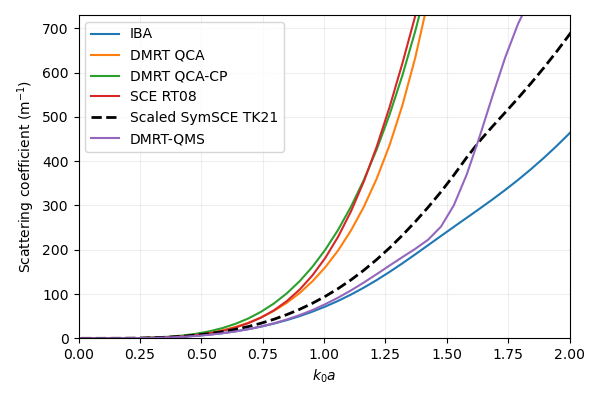

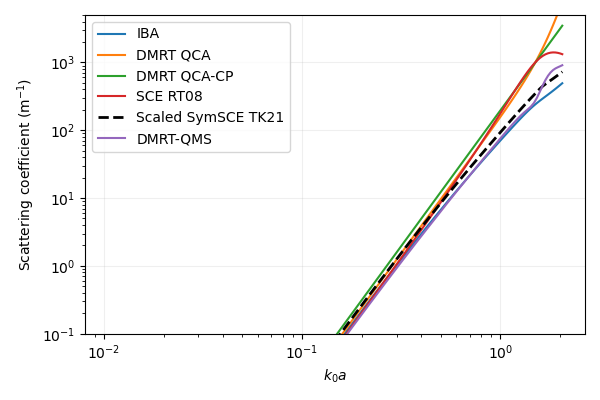

In [9]:
x = 2*np.pi * a * freqs*1e9 / 3e8

for plot in [plt.plot, plt.loglog]:

    fig = plt.figure(figsize=(6, 4))
    plot(x, get_mf(mf_iba, "ks"), label="IBA")
    #plt.plot(density, getl(iba_mg, "ks"), label="IBA - MG")
    #plt.plot(density, getl(iba_inverted, "ks"), label="IBA Auto inverted field")
    plot(x, get_mf(mf_dmrt, "ks"), label='DMRT QCA')
    plot(x, get_mf(mf_dmrt_cp, "ks"), label='DMRT QCA-CP')
    #plt.plot(density, getl(rayleigh, "ks"), label='Rayleigh')

    #plot(x, get_mf(mf_symsce, "ks"), lw=3, label='Sym SCE T21 SR')
    plot(x, get_mf(mf_sce, "ks"), label='SCE RT08')
    plot(x, get_mf(mf_symscele, "ks"), 'k--', lw=2, label='Scaled SymSCE TK21')
    plot(2*np.pi*a*mf_dmrt_qms.freq*1e9/3e8, mf_dmrt_qms.ks, label='DMRT-QMS')
    plt.legend(loc='best')
    plt.xlabel("$k_0 a$")
    plt.ylabel("Scattering coefficient (m$^{-1}$)")

    if plot == plt.plot:
        plt.ylim((0, 730))
        plt.xlim((0, 2))
    else:
        plt.ylim((1e-1, 5e3))
        
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.savefig(f"fig-scattering-coefficient-vs-frequency-{plot.__name__}.pdf")